# Desafio 6

Neste desafio, vamos praticar _feature engineering_, um dos processos mais importantes e trabalhosos de ML. Utilizaremos o _data set_ [Countries of the world](https://www.kaggle.com/fernandol/countries-of-the-world), que contém dados sobre os 227 países do mundo com informações sobre tamanho da população, área, imigração e setores de produção.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [182]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OneHotEncoder, Binarizer, KBinsDiscretizer,
    MinMaxScaler, StandardScaler, PolynomialFeatures)

from sklearn.feature_extraction.text import (
    CountVectorizer, TfidfTransformer, TfidfVectorizer
)

from sklearn.datasets import load_digits, fetch_20newsgroups

In [183]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 8)

sns.set()

In [184]:
countries = pd.read_csv("countries.csv")

In [185]:
new_column_names = [
    "Country", "Region", "Population", "Area", "Pop_density", "Coastline_ratio",
    "Net_migration", "Infant_mortality", "GDP", "Literacy", "Phones_per_1000",
    "Arable", "Crops", "Other", "Climate", "Birthrate", "Deathrate", "Agriculture",
    "Industry", "Service"
]

countries.columns = new_column_names

countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,"48,0","0,00","23,06","163,07",700.0,"36,0","3,2","12,13","0,22","87,65",1,"46,6","20,34","0,38","0,24","0,38"
1,Albania,EASTERN EUROPE,3581655,28748,"124,6","1,26","-4,93","21,52",4500.0,"86,5","71,2","21,09","4,42","74,49",3,"15,11","5,22","0,232","0,188","0,579"
2,Algeria,NORTHERN AFRICA,32930091,2381740,"13,8","0,04","-0,39",31,6000.0,"70,0","78,1","3,22","0,25","96,53",1,"17,14","4,61","0,101","0,6","0,298"
3,American Samoa,OCEANIA,57794,199,"290,4","58,29","-20,71","9,27",8000.0,"97,0","259,5",10,15,75,2,"22,46","3,27",NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,"152,1","0,00","6,6","4,05",19000.0,"100,0","497,2","2,22",0,"97,78",3,"8,71","6,25",NaN,NaN,NaN


## Observações

Esse _data set_ ainda precisa de alguns ajustes iniciais. Primeiro, note que as variáveis numéricas estão usando vírgula como separador decimal e estão codificadas como strings. Corrija isso antes de continuar: transforme essas variáveis em numéricas adequadamente.

Além disso, as variáveis `Country` e `Region` possuem espaços a mais no começo e no final da string. Você pode utilizar o método `str.strip()` para remover esses espaços.

## Inicia sua análise a partir daqui

In [186]:
# verificando as variáveis do tipo objeto que deverão ser transformadas em numéricas
countries.dtypes

Country              object
Region               object
Population            int64
Area                  int64
Pop_density          object
Coastline_ratio      object
Net_migration        object
Infant_mortality     object
GDP                 float64
Literacy             object
Phones_per_1000      object
Arable               object
Crops                object
Other                object
Climate              object
Birthrate            object
Deathrate            object
Agriculture          object
Industry             object
Service              object
dtype: object

In [240]:
countries_pivot = pd.DataFrame({'columns': countries.columns,
                                'types': countries.dtypes,
                                'nulls': countries.isna().sum(),
                                '% nulls': countries.isna().sum() / countries.shape[0],
                                'size': countries.shape[0],
                                'uniques': countries.nunique()})
countries_pivot

,columns,types,nulls,% nulls,size,uniques
Country,Country,object,0,0.000000,227,227
Region,Region,object,0,0.000000,227,11
Population,Population,int64,0,0.000000,227,227
Area,Area,int64,0,0.000000,227,226
Pop_density,Pop_density,float64,0,0.000000,227,219
Coastline_ratio,Coastline_ratio,float64,0,0.000000,227,151
Net_migration,Net_migration,float64,3,0.013216,227,157
Infant_mortality,Infant_mortality,float64,3,0.013216,227,220
GDP,GDP,float64,1,0.004405,227,130
Literacy,Literacy,float64,18,0.079295,227,140


In [187]:
countries.isnull().sum()

Country              0
Region               0
Population           0
Area                 0
Pop_density          0
Coastline_ratio      0
Net_migration        3
Infant_mortality     3
GDP                  1
Literacy            18
Phones_per_1000      4
Arable               2
Crops                2
Other                2
Climate             22
Birthrate            3
Deathrate            4
Agriculture         15
Industry            16
Service             15
dtype: int64

In [188]:
# substituindo a vírgula por ponto nas variáveis objetos
countries.iloc[:, 4:] = countries.iloc[:, 4:].replace(',', '.', regex=True)

In [189]:
countries.head()

,Country,Region,Population,Area,Pop_density,Coastline_ratio,Net_migration,Infant_mortality,GDP,Literacy,Phones_per_1000,Arable,Crops,Other,Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1,46.6,20.34,0.38,0.24,0.38
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31,6000.0,70.0,78.1,3.22,0.25,96.53,1,17.14,4.61,0.101,0.6,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10,15,75,2,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.6,4.05,19000.0,100.0,497.2,2.22,0,97.78,3,8.71,6.25,NaN,NaN,NaN


In [190]:
# transformando em dados do tipo numéricos
countries.iloc[:, 4:] = countries.iloc[:, 4:].astype(float)
countries.iloc[:, 4:].dtypes

Pop_density         float64
Coastline_ratio     float64
Net_migration       float64
Infant_mortality    float64
GDP                 float64
Literacy            float64
Phones_per_1000     float64
Arable              float64
Crops               float64
Other               float64
Climate             float64
Birthrate           float64
Deathrate           float64
Agriculture         float64
Industry            float64
Service             float64
dtype: object

In [191]:
# retirar os espaços em branco de Country e Region
countries.Country = countries.Country.str.strip()
countries.Region = countries.Region.str.strip()

## Questão 1

Quais são as regiões (variável `Region`) presentes no _data set_? Retorne uma lista com as regiões únicas do _data set_ com os espaços à frente e atrás da string removidos (mas mantenha pontuação: ponto, hífen etc) e ordenadas em ordem alfabética.

In [192]:
def q1():
    return sorted(list(countries['Region'].unique()))  # ou list(countries['Region'].sort_values().unique())
q1()

['ASIA (EX. NEAR EAST)',
 'BALTICS',
 'C.W. OF IND. STATES',
 'EASTERN EUROPE',
 'LATIN AMER. & CARIB',
 'NEAR EAST',
 'NORTHERN AFRICA',
 'NORTHERN AMERICA',
 'OCEANIA',
 'SUB-SAHARAN AFRICA',
 'WESTERN EUROPE']

## Questão 2

Discretizando a variável `Pop_density` em 10 intervalos com `KBinsDiscretizer`, seguindo o encode `ordinal` e estratégia `quantile`, quantos países se encontram acima do 90º percentil? Responda como um único escalar inteiro.

23

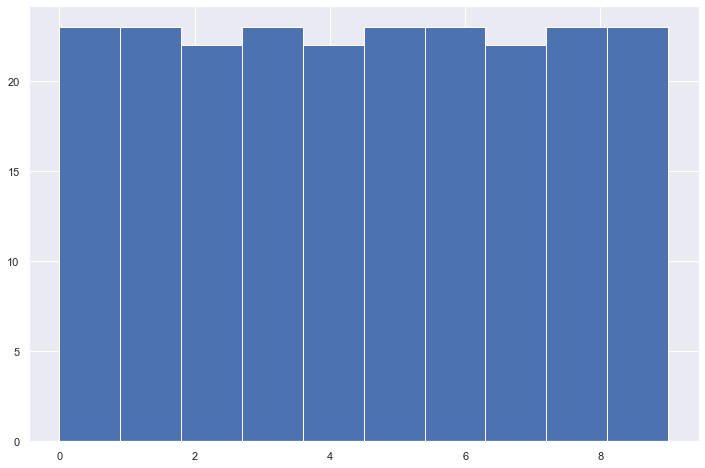

In [241]:
def q2():
    discretizer = KBinsDiscretizer(n_bins=10, encode="ordinal", strategy="quantile")
    score_bins = discretizer.fit_transform(countries[["Pop_density"]])
    plt.hist(score_bins)
    
    return np.count_nonzero(score_bins >= 9.0)
q2()

# Questão 3

Se codificarmos as variáveis `Region` e `Climate` usando _one-hot encoding_, quantos novos atributos seriam criados? Responda como um único escalar.

In [263]:
def q3():    
    one_hot_encoder = OneHotEncoder()
    encoder = one_hot_encoder.fit_transform(countries[["Region", "Climate"]].fillna('0').astype('str'))

    return encoder.shape[1]
q3()

18

## Questão 4

Aplique o seguinte _pipeline_:

1. Preencha as variáveis do tipo `int64` e `float64` com suas respectivas medianas.
2. Padronize essas variáveis.

Após aplicado o _pipeline_ descrito acima aos dados (somente nas variáveis dos tipos especificados), aplique o mesmo _pipeline_ (ou `ColumnTransformer`) ao dado abaixo. Qual o valor da variável `Arable` após o _pipeline_? Responda como um único float arredondado para três casas decimais.

In [299]:
test_country = np.array([
    'Test Country', 'NEAR EAST', -0.19032480757326514,
    -0.3232636124824411, -0.04421734470810142, -0.27528113360605316,
    0.13255850810281325, -0.8054845935643491, 1.0119784924248225,
    0.6189182532646624, 1.0074863283776458, 0.20239896852403538,
    -0.043678728558593366, -0.13929748680369286, 1.3163604645710438,
    -0.3699637766938669, -0.6149300604558857, -0.854369594993175,
    0.263445277972641, 0.5712416961268142
])

In [302]:
test_country = test_country.reshape(-1, 20)

In [303]:
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

In [304]:
def q4():
    num_pipeline.fit(countries.iloc[:, 2:])
    arable_pipeline = num_pipeline.transform(test_country[:, 2:])

    return float(np.round(arable_pipeline[:, 9], 3))
q4()


-1.047

## Questão 5

Descubra o número de _outliers_ da variável `Net_migration` segundo o método do _boxplot_, ou seja, usando a lógica:

$$x \notin [Q1 - 1.5 \times \text{IQR}, Q3 + 1.5 \times \text{IQR}] \Rightarrow x \text{ é outlier}$$

que se encontram no grupo inferior e no grupo superior.

Você deveria remover da análise as observações consideradas _outliers_ segundo esse método? Responda como uma tupla de três elementos `(outliers_abaixo, outliers_acima, removeria?)` ((int, int, bool)).

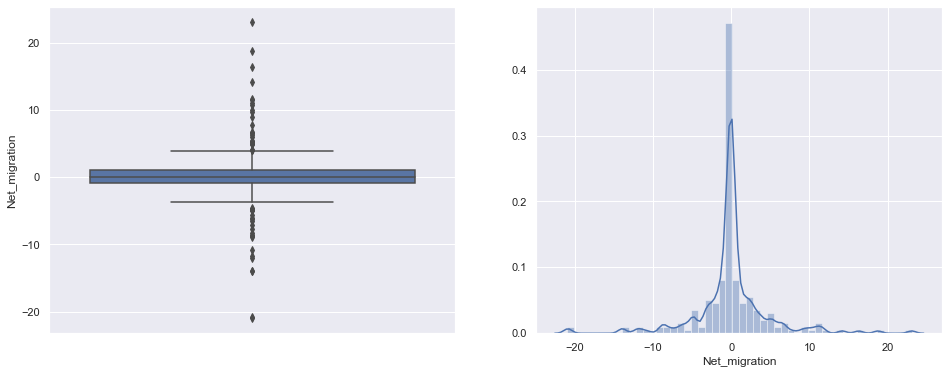

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.boxplot(countries['Net_migration'], orient="vertical", ax=ax[0])
sns.distplot(countries['Net_migration'].dropna(), ax=ax[1])

In [221]:
def q5():
    q1 = countries['Net_migration'].quantile(0.25)
    q3 = countries['Net_migration'].quantile(0.75)
    iqr = q3-q1
    
    outliers_abaixo = int(countries['Net_migration'][countries['Net_migration'] < (q1 - 1.5*iqr)].count())
    outliers_acima = int(countries['Net_migration'][countries['Net_migration'] > (q3 + 1.5*iqr)].count())   
    remover = bool((outliers_abaixo + outliers_acima)/countries['Net_migration'].shape[0] < 0.1)
                                                       
    return outliers_abaixo, outliers_acima, remover
q5()

(24, 26, False)

## Questão 6
Para as questões 6 e 7 utilize a biblioteca `fetch_20newsgroups` de datasets de test do `sklearn`

Considere carregar as seguintes categorias e o dataset `newsgroups`:

```
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)
```


Aplique `CountVectorizer` ao _data set_ `newsgroups` e descubra o número de vezes que a palavra _phone_ aparece no corpus. Responda como um único escalar.

In [227]:
categories = ['sci.electronics', 'comp.graphics', 'rec.motorcycles']
newsgroup = fetch_20newsgroups(subset="train", categories=categories, shuffle=True, random_state=42)

In [230]:
count_vectorizer = CountVectorizer()
newsgroups_counts = count_vectorizer.fit_transform(newsgroup.data)

In [269]:
type(newsgroups_counts)

scipy.sparse.csr.csr_matrix

In [270]:
def q6():
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(newsgroup.data)
    freq_phone_count = X[:, vectorizer.vocabulary_.get('phone')].sum()

    return freq_phone_count
q6()

213

## Questão 7

Aplique `TfidfVectorizer` ao _data set_ `newsgroups` e descubra o TF-IDF da palavra _phone_. Responda como um único escalar arredondado para três casas decimais.

In [273]:
def q7():
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(newsgroup['data'])
    freq_phone_tfidf = X[:, vectorizer.vocabulary_['phone']].sum()
    
    return round(freq_phone_tfidf,3)
q7()

8.888